In [2]:
import pandas as pd
import re
import emoji
import numpy as np
import wordcloud 
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import collections

In [3]:
def startsWithDateAndTime(s):
    # regex para la fecha y hora
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]) ([0-9]+):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False
  
# Encontrar el nombre de usuario para cualquier formato
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # Nombre
        '([\w]+[\s]+[\w]+):',              # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # Nombre + Nombre+ Apellido
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Teléfono MX
        '([+]\d{2} \d{2} \d{4} \d{4}):',   # Teléfono foráneo 1
        '([+]\d{1} [(]\d{3}[)] \d{3}-\d{4}):',   # Teléfono foráneo 2
        '([\w]+)[\u263a-\U0001f999]+:',    # Nombre + Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
  
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] 
# Archivo de texto
conversationPath = '.\WATexto\SORIAS.txt' # archivo de chat
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # se brinca la primera línea sobre la encriptación de WA
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)
   
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # DataFrame.
df["Date"] = pd.to_datetime(df["Date"], format= "%d/%m/%y")
df['Message'] = df['Message'].str.lower()
df['Message'] = df.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja")
df['Message'] = df.Message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja")

In [4]:
# Eliminamos entradas generadas por sistema
df = df.dropna()

In [14]:
got_dt = pd.read_csv("https://raw.githubusercontent.com/tmdavid/lotr-names-classification/master/characters_no_surnames.csv")

# Obtiene nombres y aliases
nombres = list(df.Author.unique())
aliases = list(got_dt.name.sample(len(nombres)))

# Remplaza en la columna A nombres por aliases por entrada completa
df.Author.replace(nombres, aliases, inplace=True)

#Remplaza en la columna B en cada entrada en forma de string (por partes)
for (nombre, alias) in zip(nombres, aliases):
    df.Message = df.Message.str.replace(nombre, alias)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39972 entries, 0 to 39996
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     39972 non-null  datetime64[ns]
 1   Time     39972 non-null  object        
 2   Author   39972 non-null  object        
 3   Message  39972 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB


Date   Time     Author   Message
0 2019-11-21  10:57       Milo    ke día
1 2019-11-21  10:57       Milo         ?
2 2019-11-21  10:57       Milo  cuota ??
3 2019-11-21  11:03   Henderch      jaja
4 2019-11-21  11:12  Gorhendad      jaja

In [22]:
# Autores únicos
Autores= df.Author.unique()
Autores.shape[0]

82

In [24]:
import regex
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

Autores= df.Author.unique()
total_authors= Autores.shape[0]
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<multimedia omitido>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [26]:
print("Estadísticas del grupo")
print("Autores:", total_authors)
print("Mensajes:", total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links",links)

Estadísticas del grupo
Autores: 82
Mensajes: 39972
Media: 7813
Emojis: 13437
Links 349


In [27]:
media_messages_df = df[df['Message'] == '<multimedia omitido>']
messages_df = df.drop(media_messages_df.index)

In [28]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [29]:
messages_df.head()

Date   Time     Author   Message emoji  urlcount  Letter_Count  \
0 2019-11-21  10:57       Milo    ke día    []         0             6   
1 2019-11-21  10:57       Milo         ?    []         0             1   
2 2019-11-21  10:57       Milo  cuota ??    []         0             8   
3 2019-11-21  11:03   Henderch      jaja    []         0             4   
4 2019-11-21  11:12  Gorhendad      jaja    []         0             4   

   Word_Count  MessageCount  
0           2             1  
1           1             1  
2           2             1  
3           1             1  
4           1             1

In [30]:
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Estadísticas de {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Mensajes enviados:', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Palabras por mensaje:', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Contenido multimedia enviado:', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis enviados:', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links enviados:', links)   
  print()

Estadísticas de Milo -
Mensajes enviados: 599
Palabras por mensaje: 7.707846410684474
Contenido multimedia enviado: 786
Emojis enviados: 571
Links enviados: 35

Estadísticas de Henderch -
Mensajes enviados: 1360
Palabras por mensaje: 6.600735294117647
Contenido multimedia enviado: 867
Emojis enviados: 641
Links enviados: 19

Estadísticas de Gorhendad -
Mensajes enviados: 3925
Palabras por mensaje: 4.065222929936306
Contenido multimedia enviado: 242
Emojis enviados: 953
Links enviados: 11

Estadísticas de Egalmoth -
Mensajes enviados: 1327
Palabras por mensaje: 4.08214016578749
Contenido multimedia enviado: 269
Emojis enviados: 2222
Links enviados: 0

Estadísticas de Rose -
Mensajes enviados: 833
Palabras por mensaje: 3.984393757503001
Contenido multimedia enviado: 107
Emojis enviados: 254
Links enviados: 1

Estadísticas de Morwen -
Mensajes enviados: 696
Palabras por mensaje: 7.293103448275862
Contenido multimedia enviado: 156
Emojis enviados: 109
Links enviados: 7

Estadísticas de Húr

Contenido multimedia enviado: 4
Emojis enviados: 3
Links enviados: 0

Estadísticas de Aranuir -
Mensajes enviados: 10
Palabras por mensaje: 3.5
Contenido multimedia enviado: 1
Emojis enviados: 1
Links enviados: 0

Estadísticas de Wilimar -
Mensajes enviados: 4
Palabras por mensaje: 21.0
Contenido multimedia enviado: 1
Emojis enviados: 4
Links enviados: 2

Estadísticas de Faramir -
Mensajes enviados: 9
Palabras por mensaje: 4.222222222222222
Contenido multimedia enviado: 0
Emojis enviados: 11
Links enviados: 0

Estadísticas de Vëantur -
Mensajes enviados: 1
Palabras por mensaje: 4.0
Contenido multimedia enviado: 0
Emojis enviados: 0
Links enviados: 0

Estadísticas de Hendor -
Mensajes enviados: 4
Palabras por mensaje: 6.75
Contenido multimedia enviado: 0
Emojis enviados: 7
Links enviados: 0

Estadísticas de Tar-Ancalimë -
Mensajes enviados: 31
Palabras por mensaje: 10.419354838709678
Contenido multimedia enviado: 0
Emojis enviados: 3
Links enviados: 0

Estadísticas de Lalia -
Mensajes e

In [31]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print('Emojis enviados:',total_emojis)

Emojis enviados: 557


In [32]:
import collections
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

emoji  count
0       🤣   2782
1       😂    576
2       🤗    417
3       🤪    351
4       😱    290
..    ...    ...
552     🛫      1
553     🐳      1
554     🐵      1
555     🤡      1
556     ♾      1

[557 rows x 2 columns]

In [33]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Distribución de Emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [34]:
# Crear lista de autores para crear gráficos de uso dee emoji's para cada autor
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(collections.Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Milo


Emoji Distribution for Henderch


Emoji Distribution for Gorhendad


Emoji Distribution for Egalmoth


Emoji Distribution for Rose


Emoji Distribution for Morwen


Emoji Distribution for Húrin


Emoji Distribution for Isembard


Emoji Distribution for Griffo


Emoji Distribution for Ivorwen


Emoji Distribution for Fíriel


Emoji Distribution for Rómendacil


Emoji Distribution for Sapphira


Emoji Distribution for Ardamir


Emoji Distribution for Imrazôr


Emoji Distribution for Folcred


Emoji Distribution for Ulfang


Emoji Distribution for Gilraen


Emoji Distribution for Belen


Emoji Distribution for Bowman


Emoji Distribution for Forlong


Emoji Distribution for Heorrenda


Emoji Distribution for Gram


Emoji Distribution for Baranor


Emoji Distribution for Radagast


Emoji Distribution for Haldan


Emoji Distribution for Primrose


Emoji Distribution for Finwë


Emoji Distribution for Hugo


Emoji Distribution for Beldis


Emoji Distribution for Lindissë


Emoji Distribution for Beleg


Emoji Distribution for Berylla


Emoji Distribution for Dina


Emoji Distribution for Farin


Emoji Distribution for Eärendur


Emoji Distribution for Angrim


Emoji Distribution for Urwen


Emoji Distribution for Gerontius


Emoji Distribution for Aranwë


Emoji Distribution for Duilin


Emoji Distribution for Rían


Emoji Distribution for Erling


Emoji Distribution for Bard


Emoji Distribution for Eofor


Emoji Distribution for Haldir


Emoji Distribution for Holman


Emoji Distribution for Daeron


Emoji Distribution for Arwen


Emoji Distribution for Náli


Emoji Distribution for Gruffo


Emoji Distribution for Elenwë


Emoji Distribution for Mallor


Emoji Distribution for Theobald


Emoji Distribution for Malantur


Emoji Distribution for Lúthien


Emoji Distribution for Eöl


Emoji Distribution for Hending


Emoji Distribution for Silmo


Emoji Distribution for Nimrodel


Emoji Distribution for Denethor


Emoji Distribution for Cottar


Emoji Distribution for Beldir


Emoji Distribution for Elfwine


Emoji Distribution for Isilmo


Emoji Distribution for Angamaitë


Emoji Distribution for Soronto


Emoji Distribution for Hildigard


Emoji Distribution for Fingon


Emoji Distribution for Buffo


Emoji Distribution for Aranuir


Emoji Distribution for Wilimar


Emoji Distribution for Faramir


Emoji Distribution for Vëantur


Emoji Distribution for Hendor


Emoji Distribution for Tar-Ancalimë


Emoji Distribution for Lalia


Emoji Distribution for Brand


Emoji Distribution for Tarciryan


Emoji Distribution for Númendil


Emoji Distribution for Menegilda


Emoji Distribution for Borlach


In [35]:
autor_df = messages_df.groupby("Author").sum()
autor_df

urlcount  Letter_Count  Word_Count  MessageCount
Author                                                     
Angamaitë         2           844         103            14
Angrim            0          1429         206            68
Aranuir           0           196          35            10
Aranwë            8          3969         663            67
Ardamir          28        120770       29720          3258
...             ...           ...         ...           ...
Theobald          1           112          11             4
Ulfang            3         15743        2719           462
Urwen            26          9524        1638           117
Vëantur           0            26           4             1
Wilimar           2           559          84             4

[82 rows x 4 columns]

Text(0, 0.5, 'Autor')

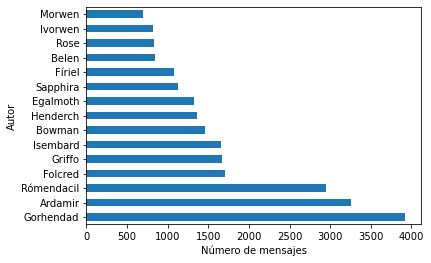

In [36]:
messages_df['Author'].value_counts().head(15).plot.barh() 
plt.xlabel('Número de mensajes')
plt.ylabel('Autor')

In [38]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount", labels={'Date':'Fecha', 'MessageCount':'Mensajes'}, title='Número de mensajes a través del tiempo.')
fig.update_xaxes(nticks=20)
fig.show()

In [42]:
def dayofweek(i):
  l = ["Lunes", "Martes", "Miércoes", "Jueves", "Viernes", "Sábado", "Domingo"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,6000]
    )),
  showlegend=False
)
fig.show()

Text(0, 0.5, 'Fecha')

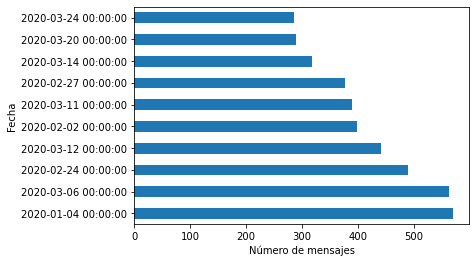

In [40]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

Text(0, 0.5, 'Hora')

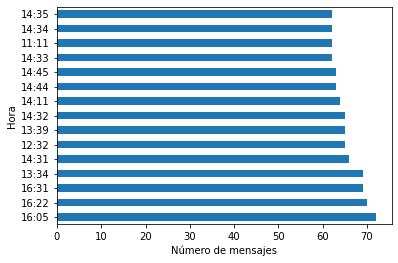

In [41]:
messages_df['Time'].value_counts().head(15).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Número de mensajes')
plt.ylabel('Hora')

In [43]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2020-03-17 00:00:00
Time                                                        22:32
Author                                                    Ardamir
Message         i'm bored i'm bored i'm bored i'm bored i'm bo...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                24063
Word_Count                                                  11787
MessageCount                                                    1
Name: 16347, dtype: object

In [44]:
text = " ".join(review for review in messages_df.Message)
print ("Hay {} palabras en todos los mensajes.".format(len(text)))

Hay 1027107 palabras en todos los mensajes.


In [45]:
from nltk.corpus import stopwords
nltk.download("stopwords")
from wordcloud import WordCloud 
stopwords = set(stopwords.words('spanish', 'english')) 
stopwords.update([ "jaja", "com", "http","https", "pues","pue","www", "I'm","bored", "Aburrí", "papol", "fito","pirata"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");


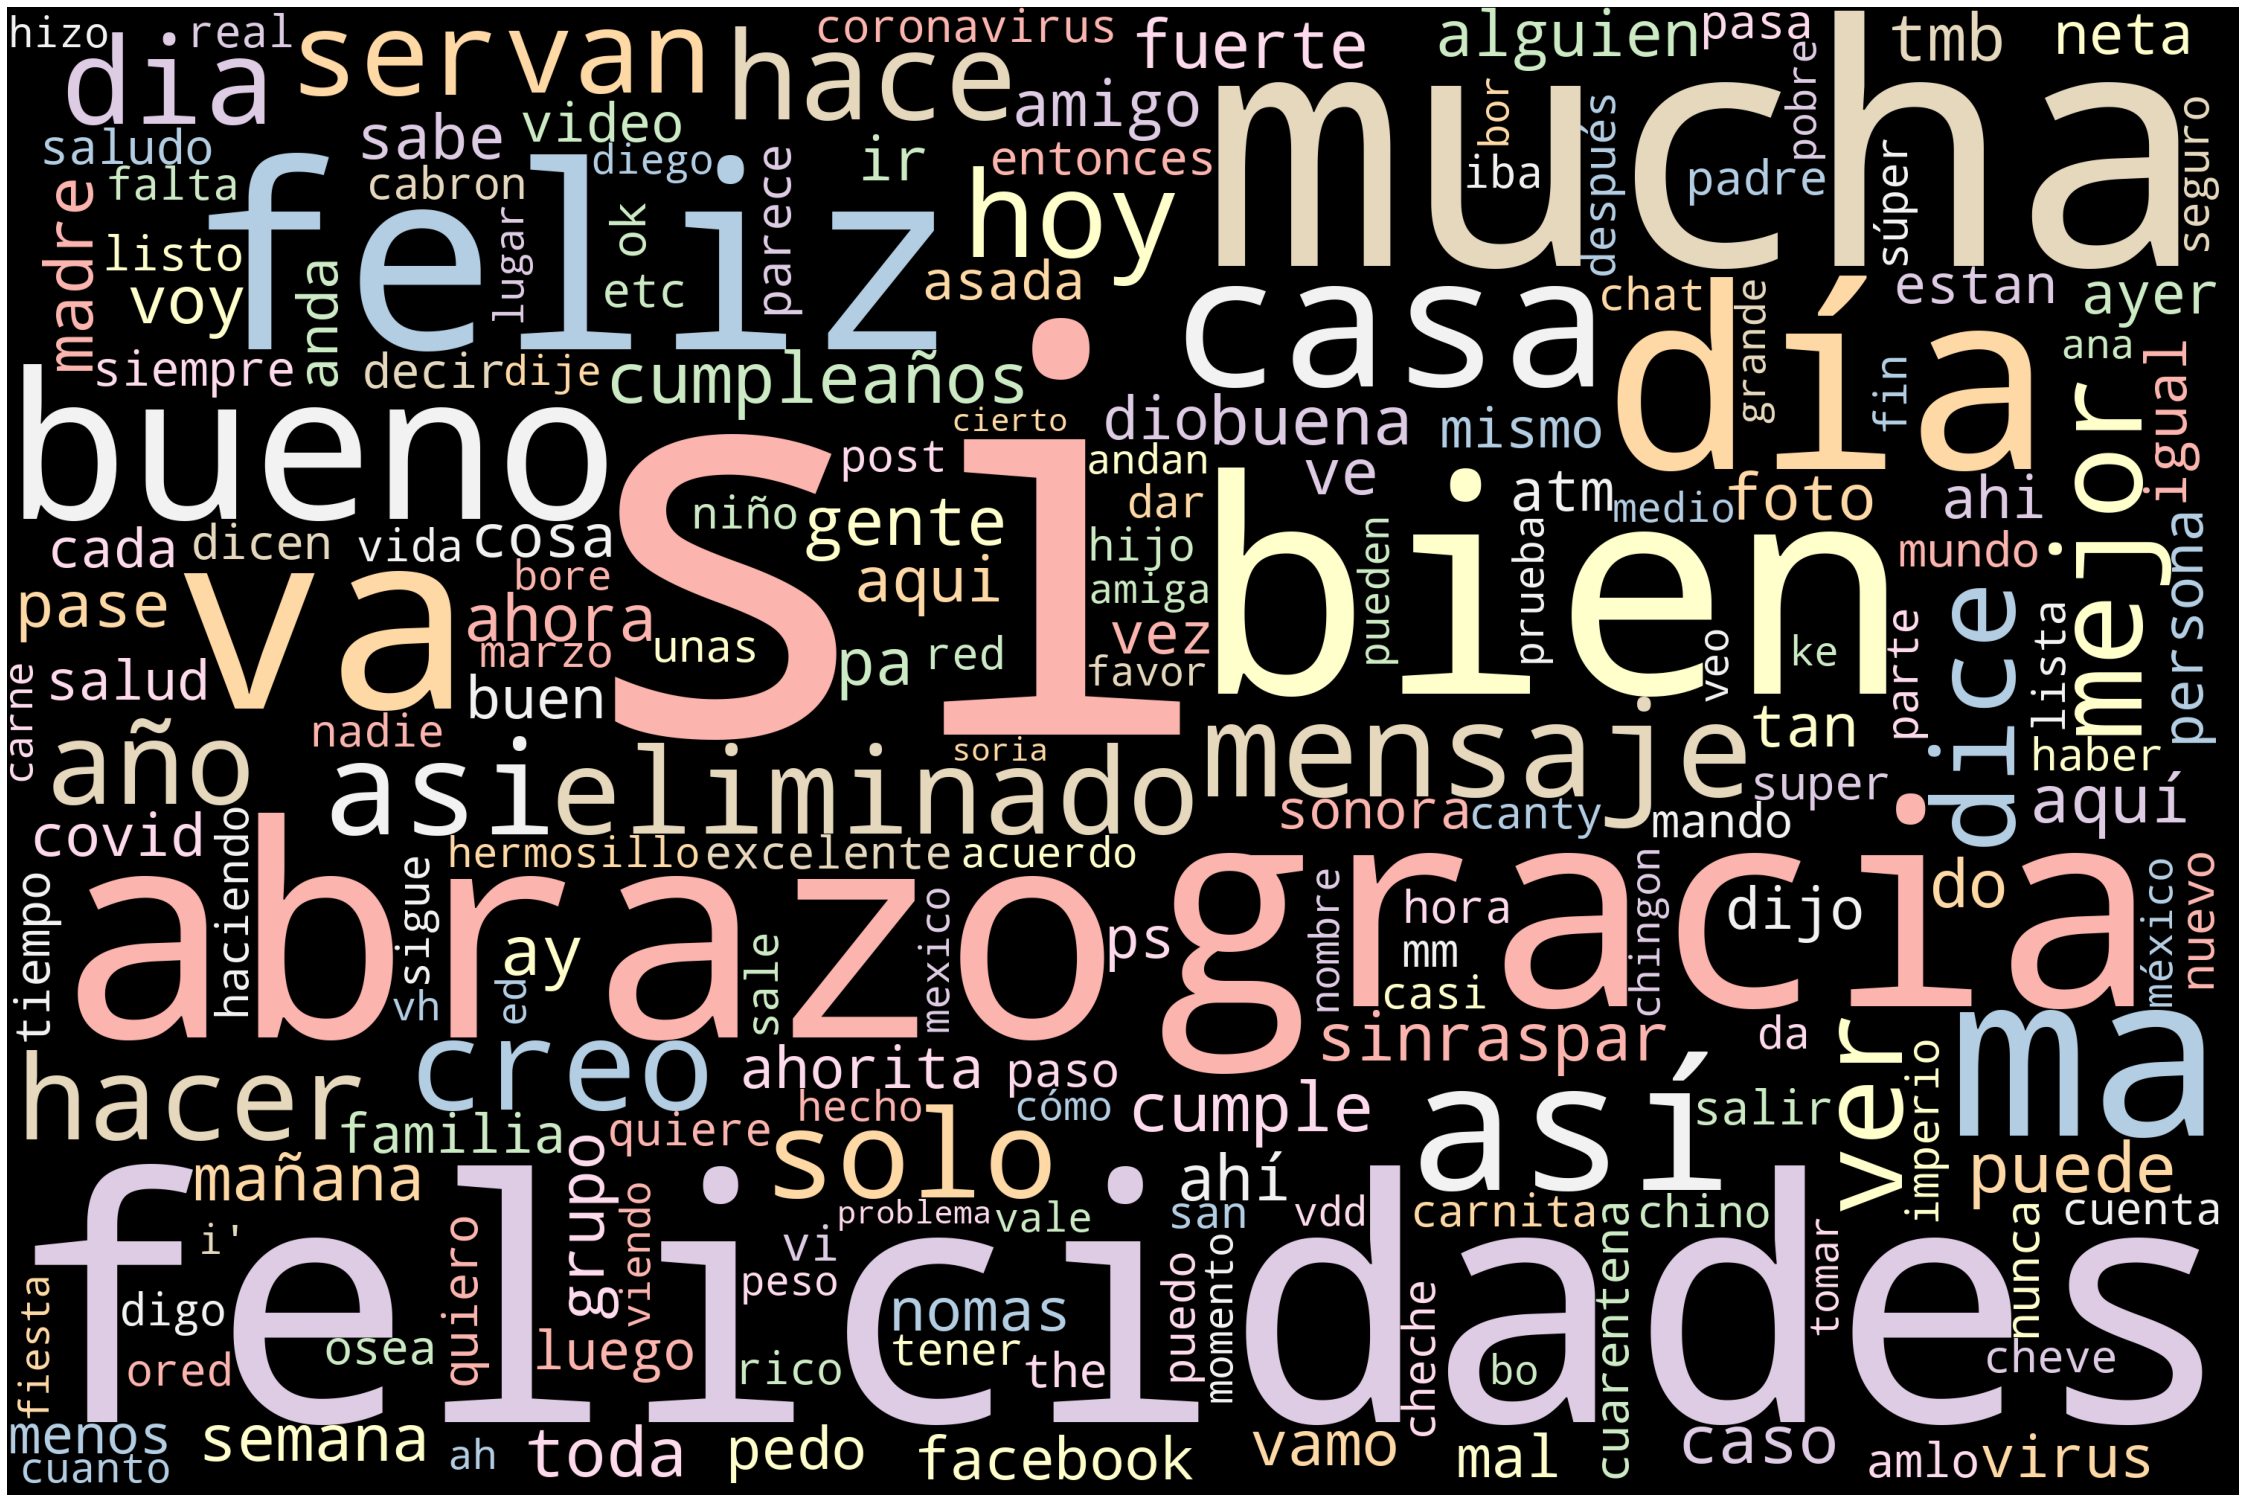

In [47]:
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = stopwords).generate(text)
# Plot
plot_cloud(wordcloud)

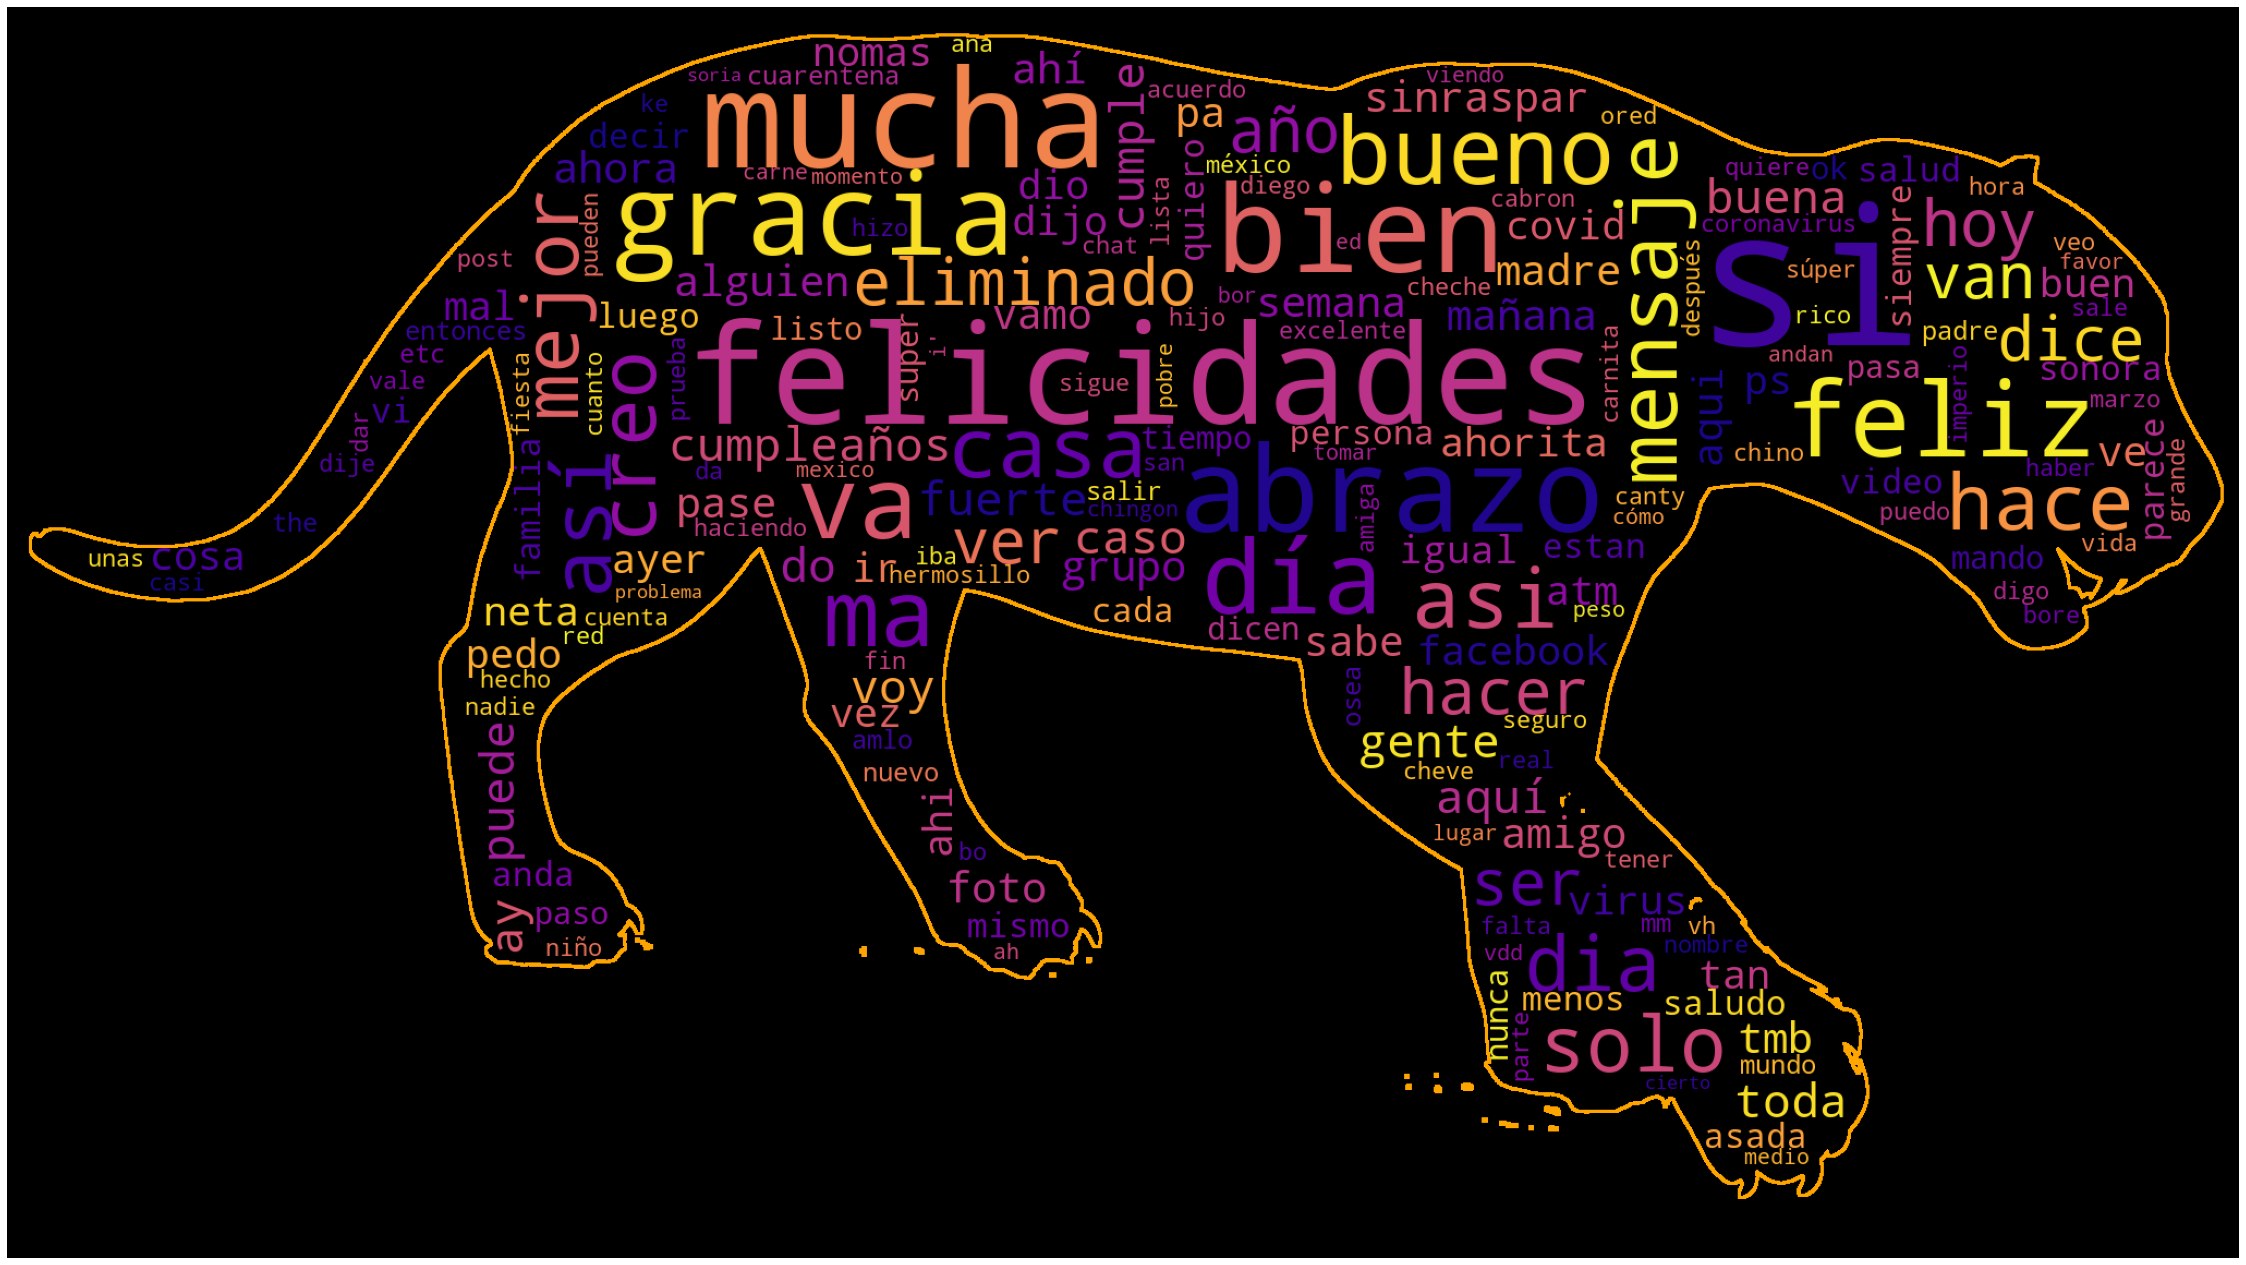

In [50]:
# Import packages
from PIL import Image
import urllib
import requests
# Import image to np.array
mask = np.array(Image.open(requests.get('https://pngriver.com/wp-content/uploads/2017/12/download-Jaguar-PNG-transparent-images-transparent-backgrounds-PNGRIVER-COM-jaguar_PNG20746.png', stream=True).raw))
# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='plasma', contour_width=4, contour_color='orange', collocations=False, stopwords = stopwords, mask=mask).generate(text)
# Plot
plot_cloud(wordcloud)
